In [3]:
# ======================================================
# 1. Import Libraries
# ======================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")


In [4]:
df=pd.read_csv("Life.csv")

In [5]:
df.head(100)


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Argentina,2000,Developing,74.1,137.0,12,7.68,1349.025282,NaN,6,...,88.0,9.21,83.0,0.1,7669.273916,3757452.0,1.2,1.1,0.764,15.0
96,Armenia,2015,Developing,74.8,118.0,1,NaN,0.000000,94.0,33,...,96.0,NaN,94.0,0.1,369.654776,291695.0,2.1,2.2,0.741,12.7
97,Armenia,2014,Developing,74.6,12.0,1,3.91,295.608714,93.0,13,...,95.0,4.48,93.0,0.1,3994.712355,29622.0,2.1,2.1,0.739,12.7
98,Armenia,2013,Developing,74.4,123.0,1,3.79,279.429081,95.0,10,...,96.0,4.55,95.0,0.1,3843.591213,289359.0,2.1,2.1,0.736,12.7


In [6]:
#  Missing Values

# Drop rows where target is missing
df = df.dropna(subset=["Life expectancy "])

# Identify numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

le = LabelEncoder()
df["Status"] = le.fit_transform(df["Status"])  # 0 = Developing, 1 = Developed

df = df.drop(columns=["Country"])

print("After cleaning:", df.shape)
print(df.isnull().sum().sum(), "missing values left")


After cleaning: (2928, 21)
0 missing values left


In [7]:
#  Handle Outliers (Clipping instead of mean replacement)
outlier_cols = [
    'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
    'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio',
    'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
    ' thinness  1-19 years', ' thinness 5-9 years',
    'Income composition of resources', 'Schooling'
]

for col in outlier_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    df[col] = df[col].clip(lower, upper)


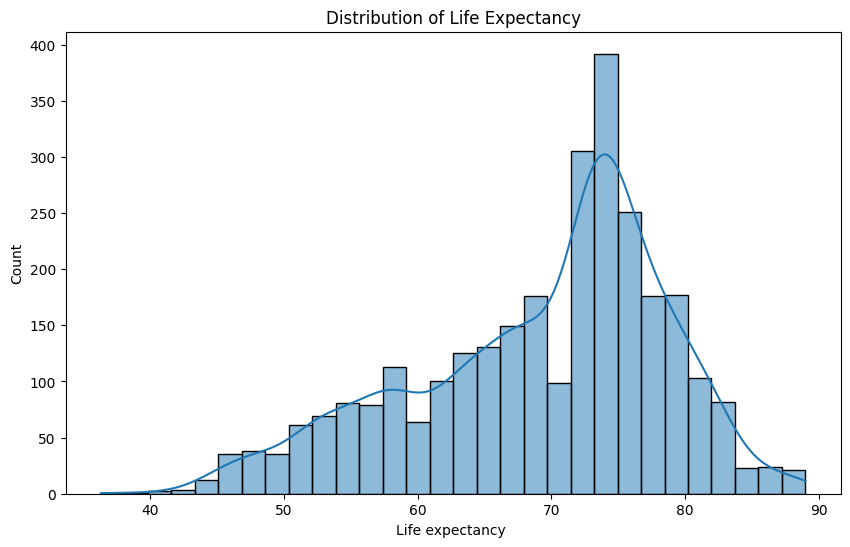

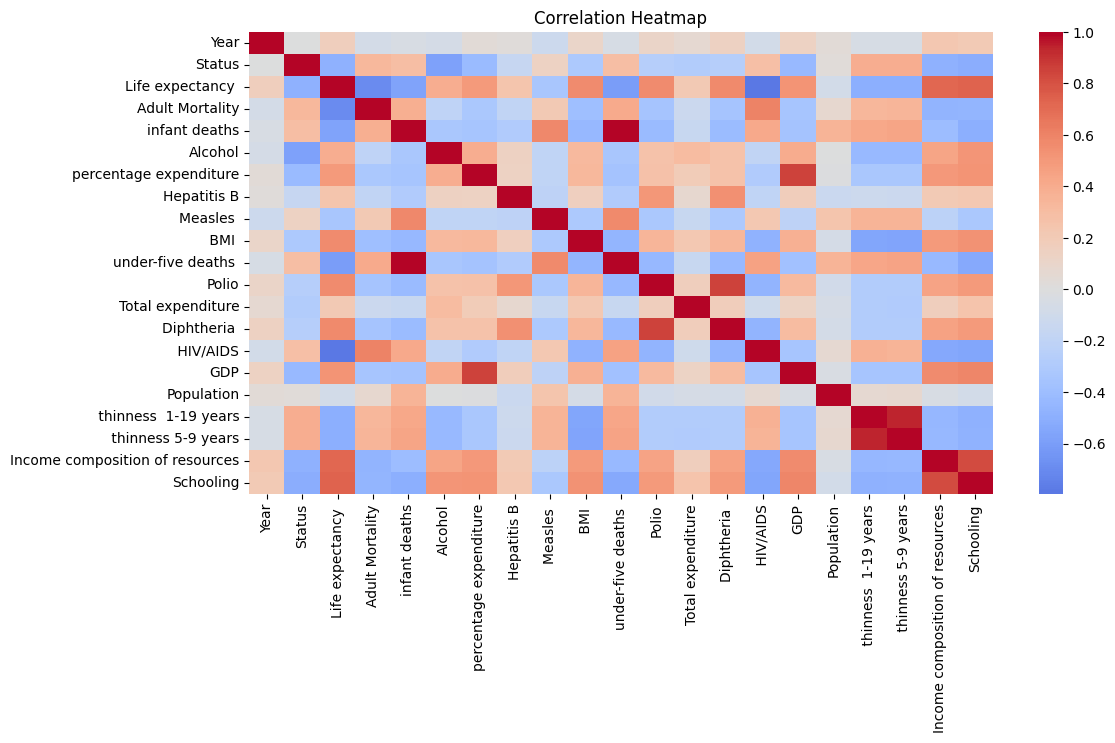

In [8]:
# . Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
sns.histplot(df["Life expectancy "], kde=True, bins=30)
plt.title("Distribution of Life Expectancy")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


In [9]:
#  Train-Test Split
X = df.drop(columns="Life expectancy ")
y = df["Life expectancy "]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (2342, 20)  Test shape: (586, 20)


In [15]:
# . Train Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)


               Model        R2       MAE      RMSE
2        Extra Trees  0.972385  0.900546  1.545538
1      Random Forest  0.966828  1.047222  1.693913
4            XGBoost  0.963943  1.154999  1.766035
3  Gradient Boosting  0.946785  1.528376  2.145479
0  Linear Regression  0.855010  2.699671  3.541402


In [16]:
#  Cross Validation for Best Model (XGBoost)
best_model = XGBRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring="r2")
print("Cross-Validation Mean R2:", cv_scores.mean())
print("Cross-Validation Std Dev:", cv_scores.std())


Cross-Validation Mean R2: 0.9617345735788232
Cross-Validation Std Dev: 0.005790675591179436


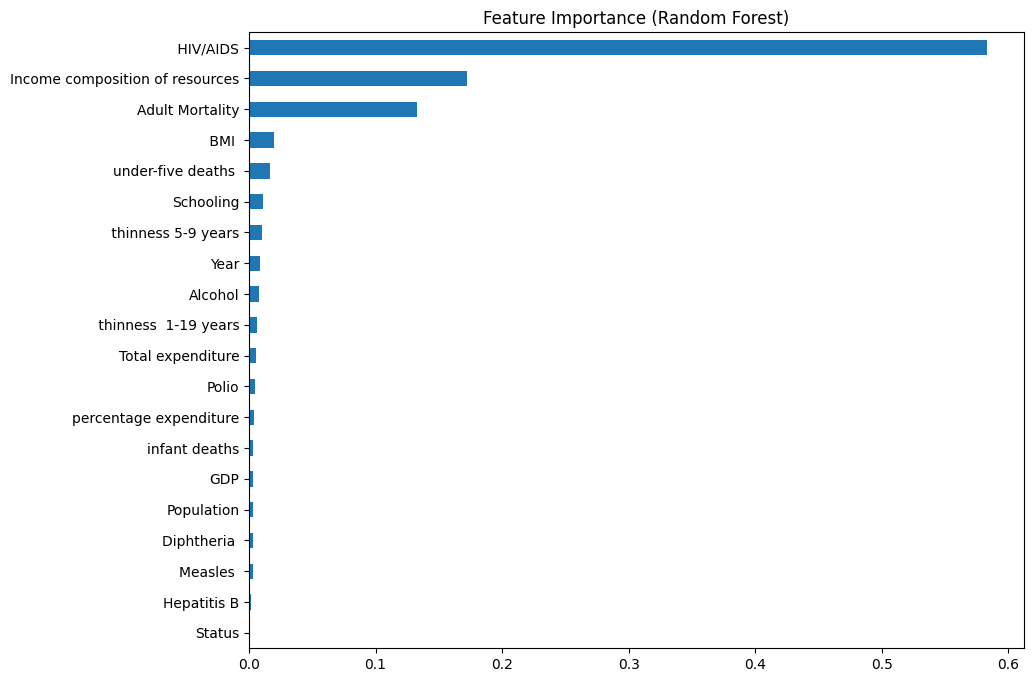

In [19]:
#  Feature Importance (from Random Forest or XGBoost)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(10,8))
plt.title("Feature Importance (Random Forest)")
plt.show()


In [20]:
#  Train Models + Evaluate All with Train-Test + Cross Validation
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Cross Validation (R2)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    results.append({
        "Model": name,
        "Train-Test R2": round(r2, 4),
        "CV Mean R2": round(cv_scores.mean(), 4),
        "CV Std Dev": round(cv_scores.std(), 4),
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4)
    })

results_df = pd.DataFrame(results).sort_values(by="CV Mean R2", ascending=False)
print("\nFinal Model Comparison:\n")
print(results_df)



Final Model Comparison:

               Model  Train-Test R2  CV Mean R2  CV Std Dev     MAE    RMSE
2        Extra Trees         0.9724      0.9697      0.0059  0.9005  1.5455
1      Random Forest         0.9668      0.9620      0.0067  1.0472  1.6939
4            XGBoost         0.9639      0.9617      0.0058  1.1550  1.7660
3  Gradient Boosting         0.9468      0.9393      0.0095  1.5284  2.1455
0  Linear Regression         0.8550      0.8510      0.0208  2.6997  3.5414


In [21]:
import pickle

best_model = ExtraTreesRegressor(random_state=42)
best_model.fit(X, y)

pickle.dump(best_model, open("life_model.pkl", "wb"))
print("Model Saved Successfully!")


Model Saved Successfully!


In [22]:
import pandas as pd
import numpy as np

# 1️ Select your trained model
# Use the model you trained in your loop
best_model = models["Extra Trees"]  # Or "Random Forest", "XGBoost", etc.

# -------------------------------
# 2️Default values for all features (median of dataset)
# -------------------------------
default_values = df.median()  # df = your cleaned Life.csv dataframe

# -------------------------------
# 3️ User Input (only key features)
# -------------------------------
# You can change these values for testing
user_input = {
    "Status": 1,                     # 0 = Developing, 1 = Developed
    "Year": 2015,
    "Adult Mortality": 150,
    "BMI ": 23.5,
    "GDP": 4000,
    "Schooling": 12.5
}

# -------------------------------
# 4️⃣ Combine defaults with user input
# -------------------------------
# Start with default values
input_data = default_values.copy()

# Update with user-provided values
for key, value in user_input.items():
    input_data[key] = value

# Make it 2D array (1 sample)
input_data = pd.DataFrame([input_data[X_train.columns]])  # ensures correct order

# -------------------------------
# 5️⃣ Predict
# -------------------------------
prediction = best_model.predict(input_data)

print("\n🎯 Predicted Life Expectancy:", round(prediction[0], 2), "years")



🎯 Predicted Life Expectancy: 73.1 years


In [24]:
import joblib
joblib.dump(best_model, "life_model.pkl")


['life_model.pkl']

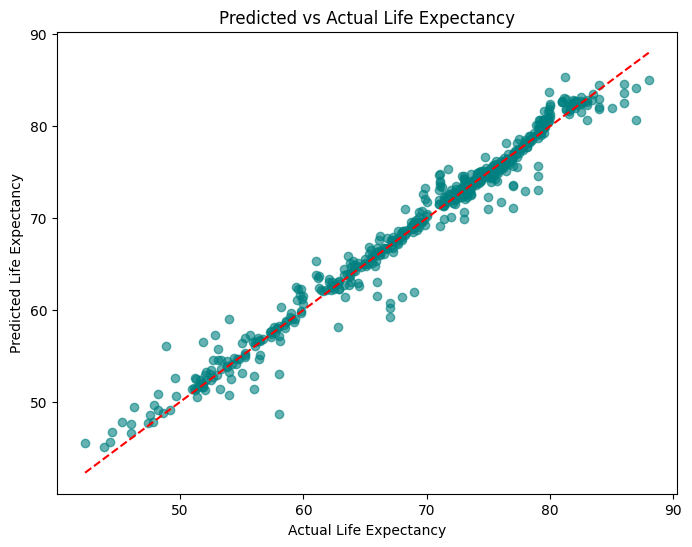

In [28]:
# Predicted vs Actual
import matplotlib.pyplot as plt

y_pred = best_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='teal', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Life Expectancy")
plt.ylabel("Predicted Life Expectancy")
plt.title("Predicted vs Actual Life Expectancy")
plt.show()


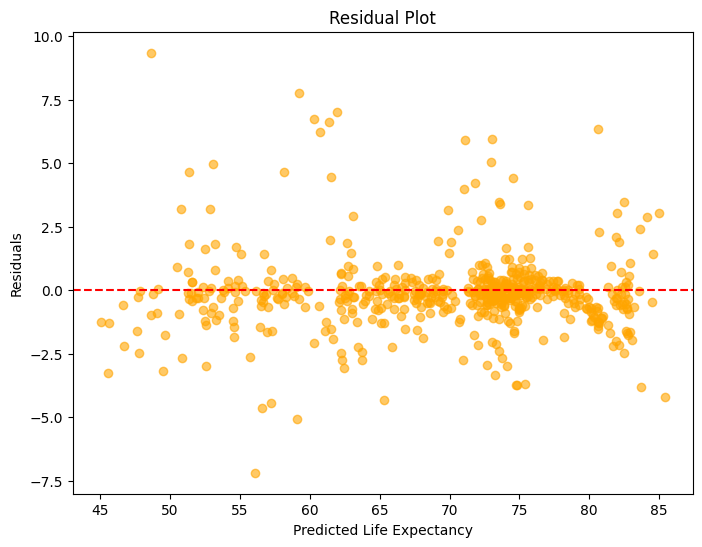

In [34]:
# Residuals
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, color='orange', alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Life Expectancy")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


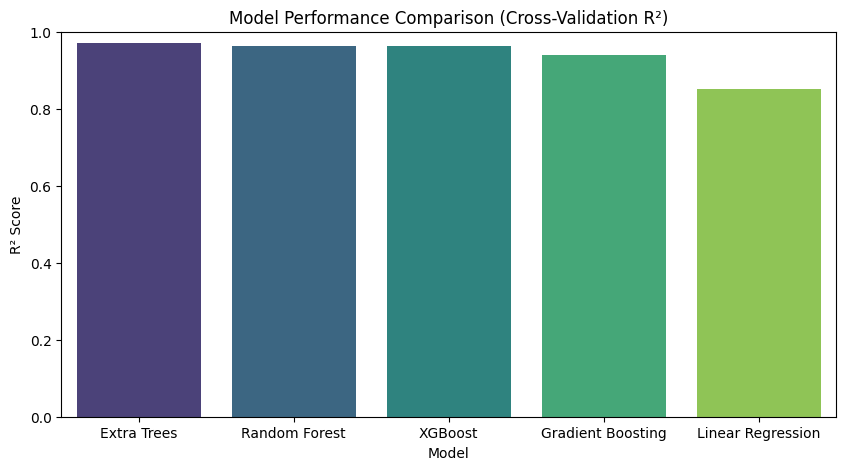

In [38]:
# Model comparison bar chart
import seaborn as sns

plt.figure(figsize=(10,5))
sns.barplot(x="Model", y="CV Mean R2", data=results_df, palette="viridis")
plt.title("Model Performance Comparison (Cross-Validation R²)")
plt.ylim(0,1)
plt.ylabel("R² Score")
plt.show()


In [ ]:
# ======================================================
# 1. Import Libraries
# ======================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
df=pd.read_csv("Life.csv")
#  Missing Values

# Drop rows where target is missing
df = df.dropna(subset=["Life expectancy "])

# Identify numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

le = LabelEncoder()
df["Status"] = le.fit_transform(df["Status"])  # 0 = Developing, 1 = Developed

df = df.drop(columns=["Country"])

print("After cleaning:", df.shape)
print(df.isnull().sum().sum(), "missing values left")

#  Handle Outliers (Clipping instead of mean replacement)
outlier_cols = [
    'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure',
    'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio',
    'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
    ' thinness  1-19 years', ' thinness 5-9 years',
    'Income composition of resources', 'Schooling'
]

for col in outlier_cols:
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    df[col] = df[col].clip(lower, upper)


# . Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
sns.histplot(df["Life expectancy "], kde=True, bins=30)
plt.title("Distribution of Life Expectancy")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

#  Train-Test Split
X = df.drop(columns="Life expectancy ")
y = df["Life expectancy "]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

# . Train Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print(results_df)
#  Cross Validation for Best Model (XGBoost)
best_model = XGBRegressor(random_state=42)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring="r2")
print("Cross-Validation Mean R2:", cv_scores.mean())
print("Cross-Validation Std Dev:", cv_scores.std())
#  Feature Importance (from Random Forest or XGBoost)
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind="barh", figsize=(10,8))
plt.title("Feature Importance (Random Forest)")
plt.show()
#  Train Models + Evaluate All with Train-Test + Cross Validation
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Cross Validation (R2)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

    results.append({
        "Model": name,
        "Train-Test R2": round(r2, 4),
        "CV Mean R2": round(cv_scores.mean(), 4),
        "CV Std Dev": round(cv_scores.std(), 4),
        "MAE": round(mae, 4),
        "RMSE": round(rmse, 4)
    })

results_df = pd.DataFrame(results).sort_values(by="CV Mean R2", ascending=False)
print("\nFinal Model Comparison:\n")
print(results_df)
import pandas as pd
import numpy as np

# 1️ Select your trained model
# Use the model you trained in your loop
best_model = models["Extra Trees"]  # Or "Random Forest", "XGBoost", etc.

# -------------------------------
# 2️Default values for all features (median of dataset)
# -------------------------------
default_values = df.median()  # df = your cleaned Life.csv dataframe

# -------------------------------
# 3️ User Input (only key features)
# -------------------------------
# You can change these values for testing
user_input = {
    "Status": 1,                     # 0 = Developing, 1 = Developed
    "Year": 2015,
    "Adult Mortality": 150,
    "BMI ": 23.5,
    "GDP": 4000,
    "Schooling": 12.5
}

# -------------------------------
# 4️⃣ Combine defaults with user input
# -------------------------------
# Start with default values
input_data = default_values.copy()

# Update with user-provided values
for key, value in user_input.items():
    input_data[key] = value

# Make it 2D array (1 sample)
input_data = pd.DataFrame([input_data[X_train.columns]])  # ensures correct order

# -------------------------------
# 5️⃣ Predict
# -------------------------------
prediction = best_model.predict(input_data)

print("\n🎯 Predicted Life Expectancy:", round(prediction[0], 2), "years")

